#Regression Model Version

# Reference Material

#https://www.scribd.com/document/826659027/Novel-Optimization-Approach-for-Stock-Price-Forecasting-Using

#NOTES
The LSTM's ONLY ROLE is to predict prices, NOT decide whether to buy / sell / hold

A separate function takes the predictions of the LSTM, analyzes rise / fall trends, then decides whether to buy / sell / hold

#-
While the LSTM aims to predict prices, WE DO NOT NECESSARILY CARE about matching prices. What we care about is whether the rise / fall trends match.

The prupose of the LSTM predictions is to know whether stock will rise / fall today/tomorrow. While predicting the next price accurately helps, what we care more about is if the rise / fall trends are similar to the actual stock data, that way we can rely on the LTSM's prediction to decide to buy / sell / hold

Ex: The predicted stock prices could all be offset from the real data by +$1000. However that means the rise/fall trends are relatively the same. While the prices were not 'accurately' predicted, the trends are what wind up getting used.

I couldnt treat this as just a Binary Classification problem because I also needed to know the rate of change of the rise / fall, which Binary Classification couldnt provide.

#-
This logic will be using the 2nd to last signal to determine buy / sell / hold decision of 'today'. This is mostly due to the fact that I cannot consistently replicate a scenario where we do not 'Hold' on the 'present day'. However I currently have the buy / sell / hold function to try and decide every possible day. So the decision of 'yesterday' usually winds up being the same as the decision of 'today'

I am under the assumption that the agent will implement some form of 'cooldown period' in order to prevent overbuying/overselling

#-
The model is trained on the latest 2 years worth of data (65% Training - 35% Testing)
The data is chronologically ordered, so testing data is always the 'latest' stock data.
This model was designed to be trained and testes with more than 100 data points worth of data. With a larger testing dataset, the accuracy ranges between 0.7-0.9, but this range decreases as the testing size gets smaller. As such, I cannot just test on the latest 7 days worth of data without having terrible accuracy in the metrics or accurate rise/fall trends.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install yfinance --upgrade --no-cache-dir

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
import random, os
import datetime as dt

#Download Stock Data

In [16]:
# --- Set random seeds for reproducibility ---
SEED = 21

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Optional: make TensorFlow deterministic (slower but consistent)
tf.config.experimental.enable_op_determinism()

# Data ranges from today to 2 years ago
start_date = (dt.date.today() - dt.timedelta(days=365*2)).strftime("%Y-%m-%d")
current_date = (dt.date.today() - dt.timedelta(days=1)).strftime("%Y-%m-%d")

ticker = 'AAPL'
data = yf.download(ticker, start = start_date, end = current_date)
data = data[['Close']].dropna()

print(f"Start_date: {start_date}")
print(f"Current_date: {current_date}")

/tmp/ipython-input-468594768.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start = start_date, end = current_date)
[*********************100%***********************]  1 of 1 completed

Start_date: 2023-11-05
Current_date: 2025-11-03


# Normalize and Prepare Data

In [17]:
# time_step: The number of past days the model looks at to predict the next day’s price.
# If time_step = 100, the model sees 100 days of prices → predicts day 101. (hopefully...)
# X shape → (samples, 100, 1)
# y shape → (samples, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_dataset(dataset, time_step=100):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i+time_step, 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 100
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)



# Train-Test Split

In [18]:
# Splitting the dataset into training (65%) and testing (35%) sets.

train_size = int(len(X) * 0.65)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training samples: {len(X_train)}")
print(f"Testing samples (last {train_size} days): {len(X_test)}")

'''
#Splitting data, last 10 datapoints are testing data
test_size = 140

X_train = X[:-test_size]
y_train = y[:-test_size]
X_test = X[-test_size:]
y_test = y[-test_size:]

print(f"Training samples: {len(X_train)}")
print(f"Testing samples (last {test_size} days): {len(X_test)}")
'''


Training samples: 259
Testing samples (last 259 days): 140


'\n#Splitting data, last 10 datapoints are testing data\ntest_size = 140\n\nX_train = X[:-test_size]\ny_train = y[:-test_size]\nX_test = X[-test_size:]\ny_test = y[-test_size:]\n\nprint(f"Training samples: {len(X_train)}")\nprint(f"Testing samples (last {test_size} days): {len(X_test)}")\n'

# Build the MLS LSTM Model

In [19]:
# LSTM(50): 50 hidden units per LSTM layer.
# return_sequences=True: Keeps the sequence output for stacking layers.
# input_shape=(100,1): 100 time steps, 1 feature (price).
# Dense(1): Output layer predicts one continuous value???
# loss='mean_squared_error': Penalizes squared error between predicted and true prices.
# optimizer='adam': Adaptive optimizer, commonly used for time series.

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Train the Model

In [20]:
# validation_split=0.1: 10% of training data used for validation.
# epochs=100: Maximum number of passes through the data.
# batch_size=64: Updates weights every 64 samples.
# verbose=1: Shows live progress.

model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=64, verbose=1)



Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - loss: 0.2075 - val_loss: 0.0176
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0229 - val_loss: 0.1457
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0188 - val_loss: 0.0211
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0167 - val_loss: 0.0179
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0135 - val_loss: 0.0459
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0084 - val_loss: 0.0753
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0107 - val_loss: 0.0444
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0074 - val_loss: 0.0287
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0083 - val_loss: 0.0349
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0068 - val_loss: 0.0513
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0071 - val_loss: 0.0501
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0065 - val_l

# Make Predictions and Inverse Transform

In [21]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

#NOTE: You may get the warning: WARNING:tensorflow:5 out of the last 13 calls to...
#Ignore it, it's fine. I think it's just warning us about needless overhead that tensorflow is doing


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


# Evaluate Performance

In [22]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

# R²: How much variance is explained (closer to 1 = better).
# MAPE: Percent error between actual and predicted prices (closer to 0 = better).

print("R² (Train):", r2_score(y_train_inv, train_predict))
print("R² (Test):", r2_score(y_test_inv, test_predict))
print("MAPE (Test):", mean_absolute_percentage_error(y_test_inv, test_predict))



R² (Train): 0.8922262988214321
R² (Test): 0.7965462668391928
MAPE (Test): 0.03658625029273924


# Placeholder Buy/Sell/Hold Logic

In [23]:

# Converts price predictions into trading actions (Buy/Sell/Hold).
# Will predict today's price and tomorrows price, and decide from there

# threshold: relationship between threshold/change determines buy/sell/hold
# cooldown: how many days you wait before deciding to buy/sell/hold (was buying/selling for 20 straight days before)

# Checks how much higher or lower the predicted price of today is, relative to the predicted tomorrow price.
# If change rises above 1% threshold, it triggers a “Buy”.
# If it falls below 1% threshold, it triggers a “Sell”.
# Otherwise → “Hold”.

def generate_signals(predicted_prices, threshold=0.01, cooldown=0):
    signals = []
    last_action_day = -cooldown

    for i in range(len(predicted_prices) - 1):
        future_change = (predicted_prices[i + 1] - predicted_prices[i]) / predicted_prices[i]

        if i - last_action_day < cooldown:
            signals.append("Hold")
            continue
        #Literally reversed the 'Buy' and 'Sell' signals. Was buyig high and selling low
        if future_change > threshold:
            signals.append("Sell")
            last_action_day = i

        elif future_change < -threshold:
            signals.append("Buy")
            last_action_day = i

        else:
            signals.append("Hold")

    signals.append("Hold")
    return signals


# Apply Signals to Test Set

In [24]:
signals = generate_signals(test_predict.flatten(), threshold=0.005, cooldown=0) #Drop threshold lower for more frequent buy/sell/hold decisions

for i in range(30):  # Predicting 10 days, but only 9 future predictions can be made
    print(f"Predicted Today: {test_predict[i][0]:.2f}, "
          f"Predicted Tomorrow: {test_predict[i+1][0]:.2f}, "
          f"Signal: {signals[i]}")


Predicted Today: 202.31, Predicted Tomorrow: 201.88, Signal: Hold
Predicted Today: 201.88, Predicted Tomorrow: 202.49, Signal: Hold
Predicted Today: 202.49, Predicted Tomorrow: 203.30, Signal: Hold
Predicted Today: 203.30, Predicted Tomorrow: 204.16, Signal: Hold
Predicted Today: 204.16, Predicted Tomorrow: 204.74, Signal: Hold
Predicted Today: 204.74, Predicted Tomorrow: 205.34, Signal: Hold
Predicted Today: 205.34, Predicted Tomorrow: 206.25, Signal: Hold
Predicted Today: 206.25, Predicted Tomorrow: 207.59, Signal: Sell
Predicted Today: 207.59, Predicted Tomorrow: 209.27, Signal: Sell
Predicted Today: 209.27, Predicted Tomorrow: 211.14, Signal: Sell
Predicted Today: 211.14, Predicted Tomorrow: 213.04, Signal: Sell
Predicted Today: 213.04, Predicted Tomorrow: 214.87, Signal: Sell
Predicted Today: 214.87, Predicted Tomorrow: 216.55, Signal: Sell
Predicted Today: 216.55, Predicted Tomorrow: 217.46, Signal: Hold
Predicted Today: 217.46, Predicted Tomorrow: 217.17, Signal: Hold
Predicted 

# Visualize the Signals

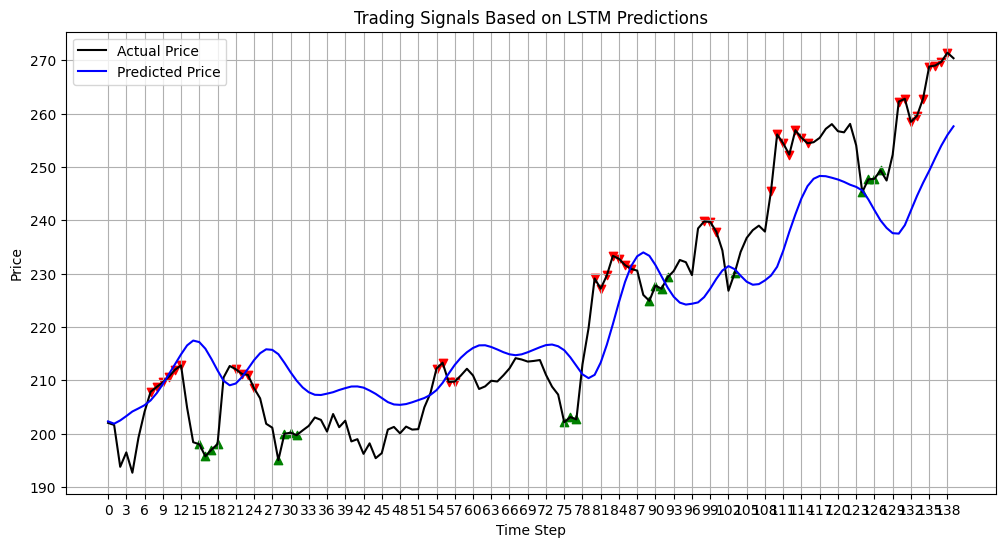

In [25]:


plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Price', color='black')
plt.plot(test_predict, label='Predicted Price', color='blue') # Mark buy/sell signals
# Mark buy/sell signals
for i, signal in enumerate(signals):
    if signal == "Buy":
        plt.scatter(i, y_test_inv[i], color='green', marker='^', label='Buy' if i == 0 else "")
    elif signal == "Sell":
        plt.scatter(i, y_test_inv[i], color='red', marker='v', label='Sell' if i == 0 else "")
plt.title("Trading Signals Based on LSTM Predictions")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.xticks(np.arange(0, 140, 3))  # x-axis ticks from 0 to 10 in steps of 2
plt.legend()
plt.grid(True)
plt.show()
# use signal from 1-2 days ago

In [26]:
# Using the 2nd to last signal
current_decision = signals[len(signals)-2]
print(f"Today, you should: {current_decision}")


if current_decision == "Buy":
    confidence = [1, 0, 0]  # [buy, sell, hold]
elif current_decision == "Sell":
    confidence = [0, 1, 0]
else:
    confidence = [0, 0, 1]

Today, you should: Sell


#All Data Points (Train+Test)

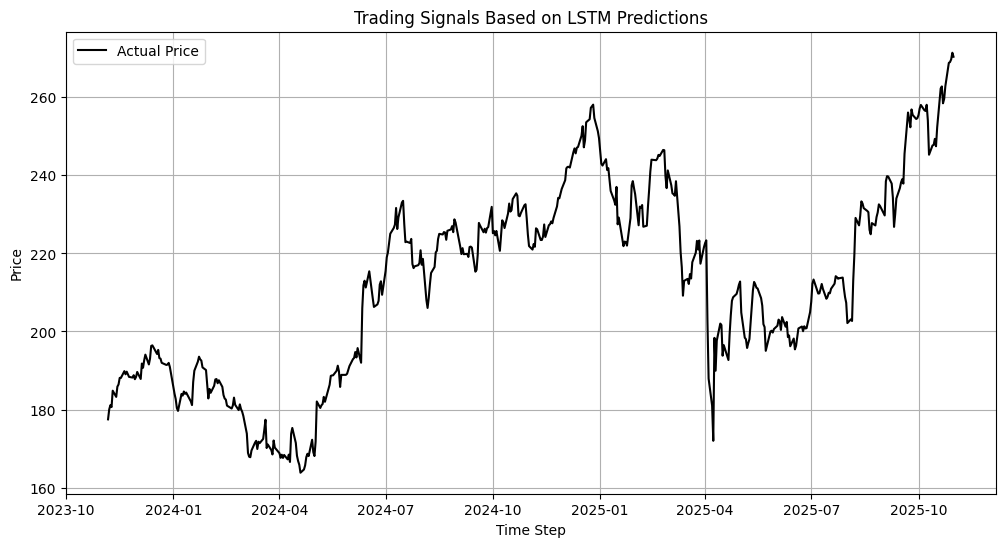

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(data, label='Actual Price', color='black')

plt.title("Trading Signals Based on LSTM Predictions")
plt.xlabel("Time Step")
plt.ylabel("Price")
#plt.xticks(np.arange(0, 130, 3))  # x-axis ticks from 0 to 10 in steps of 2
plt.legend()
plt.grid(True)
plt.show()

#Simulate Portfolio